<a href="https://colab.research.google.com/github/LucyLeng/A-Star-Search-Algorithm/blob/main/EAI6010_XiaoqingLeng_Week2_Fall_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**<center>EAI 6010 Assignment 2**<center>
##**<center>Module 2: Fast Style Transfer for Arbitrary Styles<br> Professor: Vladimir Shapiro<br> Submitted by Xiaoqing Leng<br>Date: 11/09/2022</center>**


#**Introduction**#
**Project Objectives**<br>
In this project we will use google colab to apply an unsupervised model that combining the neural algorithm of artistic style with fast style transfer networks to achieve real-time stylization for any images. Style transfer is a method of using deep neural networks to replicate, reconstruct and blend the styles of artworks by teaching artificial intelligence to understand existing artworks (Brown, 2022). This project is inspired and based on the model code in magenta and the publication "Exploring the structure of a real-time, arbitrary neural artistic stylization network" (Ghiasi et al.,2017). Additional modifications on the code were made by Dr. Vladimir Shapiro. We will use the most recent version of Tensorflow 2 to find machine learning solutions for image generation and stylization following the tutorial introduced.

#**Analysis**#
In the analysis part, we will first introduce and import the TensorFlow tools and implement the model to stylize a example content image. We will then upload and generate our own image using the same methodology.

**License & Copyright**<br>
The TensorFlow licence is listed below.



In [ ]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

**Setting Up Tools**<br>
We will start by installing and importing the Tensorflow 2 and dependencies to Google Colab. At this time, since GPU has better performance when traning the model, we will setup our GPU to run the scripts in Colab.

In [ ]:
import functools
import os

from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF Version: ", tf.__version__)
print("TF-Hub version: ", hub.__version__)
print("Eager mode enabled: ", tf.executing_eagerly())
print("GPU available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


TF Version:  2.9.2
TF-Hub version:  0.12.0
Eager mode enabled:  True
GPU available:  False


**Define image loading and visualization functions**

In [ ]:
def crop_center(image):
  """Returns a cropped square image."""
  shape = image.shape
  new_shape = min(shape[1], shape[2])
  offset_y = max(shape[1] - shape[2], 0) // 2
  offset_x = max(shape[2] - shape[1], 0) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_y, offset_x, new_shape, new_shape)
  return image

@functools.lru_cache(maxsize=None)
def load_image(image_url, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
  # Cache image file locally.
  image_path = tf.keras.utils.get_file(os.path.basename(image_url)[-128:], image_url)
  # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = plt.imread(image_path).astype(np.float32)[np.newaxis, ...]
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w  * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

def load_local_image(image_bytes, image_size=(256, 256), preserve_aspect_ratio=True):
  """Loads and preprocesses images."""
   # Load and convert to float32 numpy array, add batch dimension, and normalize to range [0, 1].
  img = image_bytes
  if img.max() > 1.0:
    img = img / 255.
  if len(img.shape) == 3:
    img = tf.stack([img, img, img], axis=-1)
  img = crop_center(img)
  img = tf.image.resize(img, image_size, preserve_aspect_ratio=True)
  return img


**Import TF-Hub module**<br>
In this section we will load the TF-Hub module from magenta.

In [6]:
# Load TF-Hub module.

hub_handle = 'https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2'
hub_module = hub.load(hub_handle)

**Load example image**<br>

2684586/2684586 [==============================] - 0s 0us/step


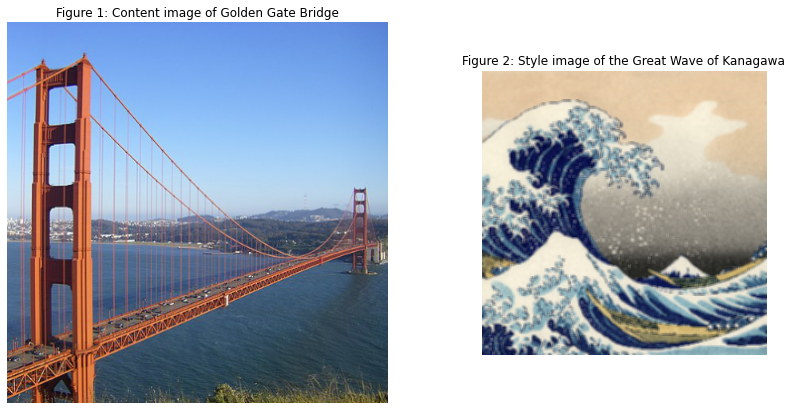

In [7]:
# Load example images

content_image_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fd/Golden_Gate_Bridge_from_Battery_Spencer.jpg/640px-Golden_Gate_Bridge_from_Battery_Spencer.jpg'  # @param {type:"string"}
style_image_url = 'https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg'  # @param {type:"string"}
output_image_size = 384  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_image(content_image_url, content_img_size)
style_image = load_image(style_image_url, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
show_n([content_image, style_image], ['Figure 1: Content image of Golden Gate Bridge', 'Figure 2: Style image of the Great Wave of Kanagawa'])

*Note*. The content image in Figure 1 represents the approximate shape of the final generated image. And the style image （Figure 2） above is what determines the approximate style of the final generated image (e.g. in color and texture).

**Demonstrate image stylization**<br>

The signature of this hub module for image stylization is:
```
outputs = hub_module(content_image, style_image)
stylized_image = outputs[0]
```
Where `content_image`, `style_image`, and `stylized_image` are expected to be 4-D Tensors with shapes `[batch_size, image_height, image_width, 3]`.
<br>In this section we need to note that in the current example we only provide a single image, so the dimension of the batch is 1, but actually we are able to process more images at the same time using the same module. Also, the input and output values of the images should be in the range of [0, 1]. The shapes of the content and style images do not necessarily have to match, but the shape of the output image is the same as the shape of the content image.

**Calculate and Display**<br>
We will further apply our model to the example image and observe the features of the output image.



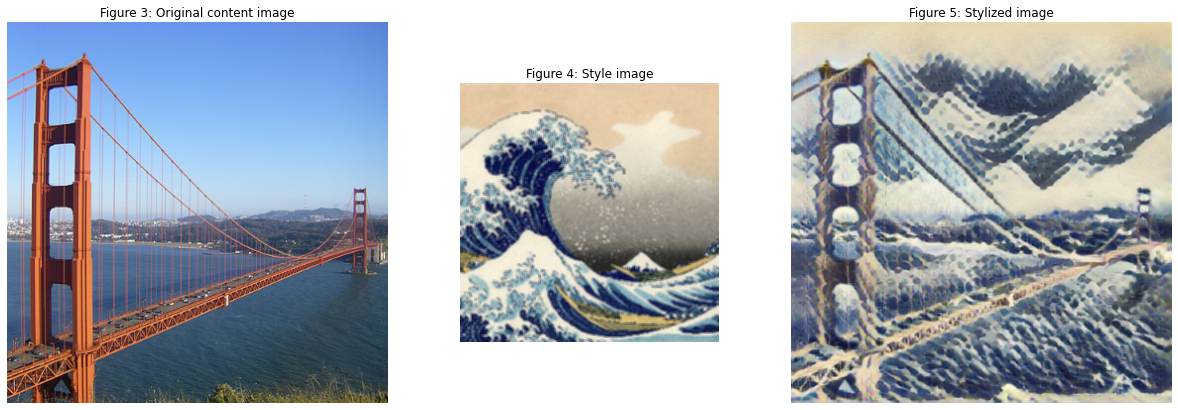

In [ ]:
# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.

outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.

show_n([content_image, style_image, stylized_image], titles=['Figure 3: Original content image', 'Figure 4: Style image', 'Figure 5: Stylized image'])

*Note.* The output image (Figure 5) exactly adopts the patterns and feature formt the style image (Figure 4) while maintianing the shape and layout fomr the original content image (Figure 3) shown above.

**Upload new example images**<br>

Browse to the style file  to be uploaded


Saving Monet.jpeg to Monet.jpeg
User uploaded file Monet.jpeg with length 196890 fbytes
Browse to the content file to be uploaded


Saving 1665_Girl_with_a_Pearl_Earring.jpeg to 1665_Girl_with_a_Pearl_Earring.jpeg
User uploaded content file 1665_Girl_with_a_Pearl_Earring.jpeg with length 215583 fbytes


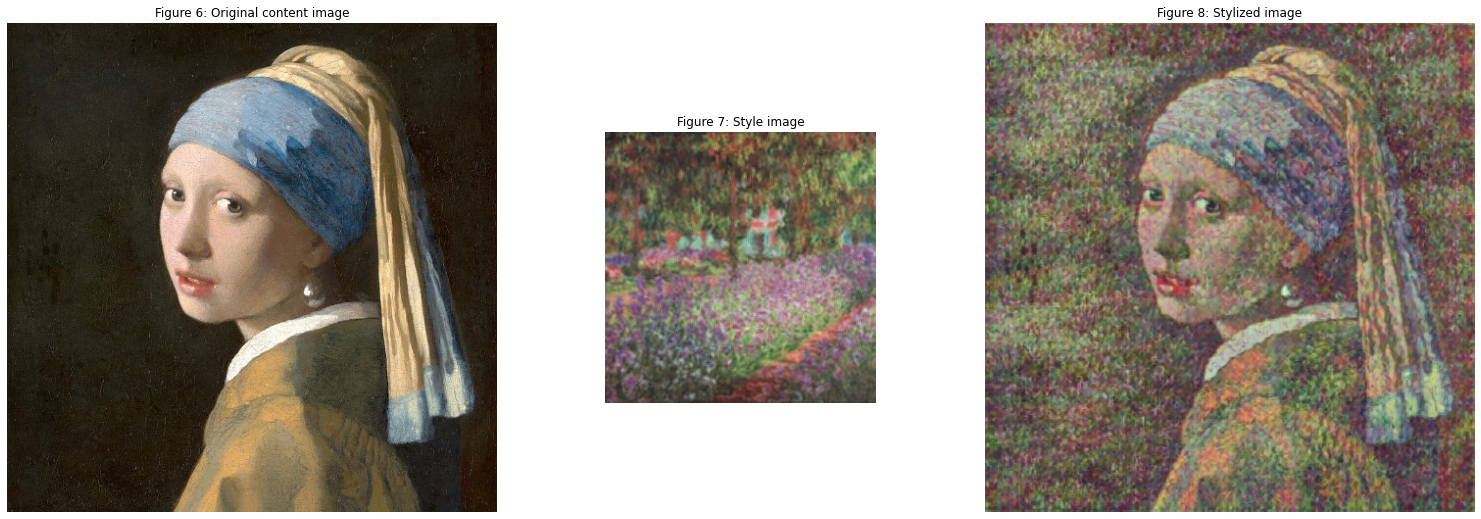

In [8]:
from google.colab import files
# load style image from the local filesystem
print("Browse to the style file  to be uploaded") 
style_uploaded = files.upload()
for fn in style_uploaded.keys():
  print("User uploaded file {name} with length {length} fbytes".format(name=fn, 
                                                      length=len(style_uploaded[fn])))
style_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# load content image from the local filesystem
print("Browse to the content file to be uploaded") 
content_uploaded = files.upload()
for fn in content_uploaded.keys():
  print("User uploaded content file {name} with length {length} fbytes".format(name=fn,
                                                      length=len(content_uploaded[fn])))
content_img = plt.imread(fn).astype(np.float32)[np.newaxis, ...]

# Load example images  
output_image_size = 500  # @param {type:"integer"}

# The content image size can be arbitrary.
content_img_size = (output_image_size, output_image_size)
# The style prediction model was trained with image size 256 and it's the 
# recommended image size for the style image (though, other sizes work as 
# well but will lead to different results).
style_img_size = (256, 256)  # Recommended to keep it at 256.

content_image = load_local_image(content_img, content_img_size) #load_image(content_image_url, content_img_size)
style_image = load_local_image(style_img, style_img_size)
style_image = tf.nn.avg_pool(style_image, ksize=[3,3], strides=[1,1], padding='SAME')
#show_n([content_image, style_image], ['Content image', 'Style image'])

# Stylize content image with given style image.
# This is pretty fast within a few milliseconds on a GPU.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

# Visualize input images and the generated stylized image.
show_n([content_image, style_image, stylized_image], titles=['Figure 6: Original content image', 'Figure 7: Style image', 'Figure 8: Stylized image'])

*Note.* As in the previous example image, here we uploaded a portrait image as the content image (Figure 6), and again, the output image (Figure 8) retains the outline of the original image and adds the touches and colors of the stylized image (Figure 7).

**Export html File**<br>
We will export the content of this notebook using nbconvert.

In [10]:
%%capture
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc
from google.colab import drive
drive.mount('/content/drive/')
%cd "/content/drive/MyDrive/Colab Notebooks/EAI6010_XiaoqingLeng_Week2_Fall_2022.ipynb"
!jupyter nbconvert --to html "/content/drive/MyDrive/Colab Notebooks/EAI6010_XiaoqingLeng_Week2_Fall_2022.ipynb"

#**Conclusion**#
In this assignment, I successfully used an unsupervised model, combined with an artistic style neural algorithm and a fast style transfer network, to stylize arbitrary images. Of course, I also encountered some difficulties. When uploading images, sometimes the images I uploaded would cause the code to report errors, but of course after I tried to compress the files, I was able to generate the images successfully. But I'm not sure how to fix this error. Although the optimal size for a sytle image should be 256x256, I have used larger images that work just as well (but not too large). Overall, I learned a lot about the application of computer vision and tried out how to use the code for image styling myself. I believe that there are still many unknowns in this field waiting to be explored, and this assignment provides us with the opportunity to be explosed to a small part of the application of this type of algorithm.


#**Reference**#

[1] Brown, A. (2022, October 12). Is artificial intelligence set to take over the art industry? Forbes. Retrieved November 9, 2022, from https://www.forbes.com/sites/anniebrown/2021/09/06/is-artificial-intelligence-set-to-take-over-the-art-industry/?sh=604dfa833c50 <br>
[2] Ghiasi, G., Lee, H., Kudlur, M., Dumoulin, V., &amp; Shlens, J. (2017, August 24). Exploring the structure of a real-time, arbitrary neural artistic stylization network. arXiv.org. Retrieved November 9, 2022, from https://arxiv.org/abs/1705.06830 